# Automatic Image Colourization using CNNs and InceptionResnetV2

## Objective
This notebook showcases my implementation of [Deep Koalarization: Image Colourization using CNNs and Inception-ResNet-v2](https://arxiv.org/abs/1712.03400), by Baldassarre et al., using PyTorch. The objective of this model is to automatically colourize grayscale images.

Images can be represented using various colour spaces such as RGB, YUV, and LAB channels. When these channels are separated and stacked back together, we get the coloured version of the image. As shown in the image below, Figure (a) represents the LAB image, while Figure (b), (c), (d) represent the L, A, B channels of the image respectively.

<p align="center">
  <img src="https://rodrigoberriel.com/assets/images/posts/color-spaces/lab-complete.png">
</p>

The overall objective of this model is to predict A and B channels of a $HxW$ image given its L channel, which is essentially a grayscale version of the image as shown above. The objective can also be defined as a mathematical function:

$$F:(X_L) \rightarrow (X_a, X_b) $$

where $X_L, X_A, X_B \in \mathbb{R}^{HxWx1}$ as each channel has a depth of 1. 

When combining the three channels together we get:
$$X=(X_L, X_A, X_B)$$ where $X \in \mathbb{R}^{HxWx3}$. $X$ is the fully coloured image that we are striving for.






## Model Architecture
<p align="center">
  <img src="https://media.arxiv-vanity.com/render-output/2918313/net.png">
</p>

The model consists of an encoder, feature extractor, fusion layer, and decoder as shown in the figure above. It leverages InceptionResnetV2, a pretrained convolutional neural network trained on ImageNet, as a high-level feature extractor to enhance the colouring process as stated in the paper.

## Installing Dependencies

In [3]:
from google.colab import drive
drive.mount("/content/gdrive", force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


Since PyTorch does not have the InceptionResnetV2 model, we use an external library to download the model instead.

In [0]:
%%capture
!pip install pretrainedmodels

In [0]:
import numpy as np
from tqdm.notebook import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data.sampler import SubsetRandomSampler

import matplotlib.pyplot as plt
from skimage.color import rgb2lab, lab2rgb, rgb2gray
import pretrainedmodels
from pretrainedmodels import utils

After downloading and importing the external model library, we download the InceptionResnetV2 model that outputs 1001 classes as the paper indicates.

In [6]:
inception = pretrainedmodels.__dict__["inceptionresnetv2"](
    num_classes=1001, 
    pretrained="imagenet+background"
)

Downloading: "http://data.lip6.fr/cadene/pretrainedmodels/inceptionresnetv2-520b38e4.pth" to /root/.cache/torch/checkpoints/inceptionresnetv2-520b38e4.pth


This notebook was trained using Google Colab's NVIDIA Tesla T4 GPU while the paper's leverages NVIDIA Tesla K80 GPU.

In [0]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Hyperparameters
Although the learning rate is consistent with the paper, validation size is defined as 10% instead of 20% in the paper. Just to stick with usual convention and the amount of training data that is present, I decided to stick with 20%. 

Since batch size and epochs were not presented in the paper, these values were decided by experimentation and using other colourization papers as a guideline.

In [0]:
VALIDATION_SIZE = 0.2
BATCH_SIZE = 64
EPOCHS = 50
LEARNING_RATE = 0.001

## Helper Functions
These functions are used throughout the code to help organize the flow.

In [0]:
def monitor_gpu():
  """
  Monitors the GPU usage throughout the script.

  Parameters:
    desc: An optional description that can be printed along with the GPU info.

  Returns:
    The allocated and cached usage in GB.
  """
  if device.type == "cuda":
    print("Memory Usage:")
    print("Allocated:", round(torch.cuda.memory_allocated(0) / 1024**3, 1), "GB")
    print("Cached:   ", round(torch.cuda.memory_cached(0) / 1024**3, 1), "GB")
  else:
    print("No GPU found.")

In [0]:
def retrieve_training_validation_samplers(train_data, validation_size):
  """
  Obtains the training and validation indices.

  Parameters:
    train_data: The training dataset as a torchvision.datasets object.
    validation_size: The % of the dataset that will be the validation set.
  
  Returns:
    A tuple of the training and validation samplers.
  """
  num_train = len(train_data)
  indices = list(range(num_train))

  np.random.shuffle(indices)
  split = int(np.floor(validation_size * num_train))

  train_idx, valid_idx = indices[split:], indices[:split]

  return SubsetRandomSampler(train_idx), SubsetRandomSampler(valid_idx)

In [0]:
def load_checkpoint(checkpoint_path, model, optimizer):
  """
  Loads the model checkpoint to resume training.

  Parameters:
    checkpoint_path: The file location of the model checkpoint.
    model: The base model without weights loaded.
    optimizer: The optimizer without weights loaded.
  
  Returns:
    The model and optimizers with the checkpoint weights and the epoch to start.
  """
  checkpoint = torch.load(checkpoint_path)
  model.load_state_dict(checkpoint["model_state_dict"])
  optimizer.load_state_dict(checkpoint["optimizer_state_dict"])

  return model, optimizer, checkpoint["epoch"]

In [0]:
def stack_lab_channels(grayscale_input, ab_input):
  """
  Stacks the L and AB channels together to create the LAB image. Then, the LAB
  image is converted to RGB.

  Parameters:
    grayscale_input: The L channel as a tensor.
    ab_input: The AB channels as a tensor.
  
  Returns:
    The RGB channels as a numpy array.
  """
  color_image = torch.cat((grayscale_input, ab_input), axis=0).numpy()
  color_image = color_image.transpose((1, 2, 0)) 

  color_image[:, :, 0:1] = color_image[:, :, 0:1] * 100
  color_image[:, :, 1:3] = color_image[:, :, 1:3] * 255 - 128   

  color_image = lab2rgb(color_image.astype(np.float64))

  return color_image

In [0]:
def convert_to_rgb(grayscale_input, ab_input, ab_ground_truth):
  """
  Converts the grayscale, predicted, and ground truth tensors into
  image-displayable numpy arrays. 

  Parameters:
    grayscale_input: The L channel as a tensor.
    ab_input: The AB channels as a tensor.
  
  Returns:
    The grayscale, predicted, and ground truth images as RGB numpy arrays.
  """
  predicted_image = stack_lab_channels(grayscale_input, ab_input)
  ground_truth_image = stack_lab_channels(grayscale_input, ab_ground_truth)
  grayscale_input = grayscale_input.squeeze().numpy()

  return grayscale_input, predicted_image, ground_truth_image

In [0]:
def display_images(grayscale, pred_image, truth_image):
  """
  Displays the grayscale, predicted image, and truth image side by side

  Parameters:
    grayscale: The grayscale image as an RGB numpy array.
    pred_image: The predicted image as an RGB numpy array.
    truth_image: The ground truth image as an RGB numpy array.
  """
  f, axarr = plt.subplots(1, 3, figsize=(20, 10))
  axarr[0].imshow(grayscale, cmap="gray")
  axarr[0].set_title("Grayscale Image (Model Input)", fontsize=20)
  axarr[1].imshow(pred_image)
  axarr[1].set_title("RGB Image (Model Output)", fontsize=20)
  axarr[2].imshow(truth_image)
  axarr[2].set_title("Actual RGB Image (Ground-truth)", fontsize=20)

## Building the Model Architecture
The encoder and decoder are built as separate PyTorch classes. Then, the `Network` class fuses the encoder's output and InceptionResnetV2's output in the feed-forward method. This fusion output is then inputted to the decoder.

In [0]:
class Encoder(nn.Module):
  """
  The encoder for the neural network. 
  The input shape is a 224x224x1 image, which is the L channel.
  """
  def __init__(self):
    super(Encoder, self).__init__()    

    self.input_ = nn.Conv2d(1, 64, 3, padding=1, stride=2)
    self.conv1 = nn.Conv2d(64, 128, 3, padding=1)
    self.conv2 = nn.Conv2d(128, 128, 3, padding=1, stride=2)
    self.conv3 = nn.Conv2d(128, 256, 3, padding=1)
    self.conv4 = nn.Conv2d(256, 256, 3, padding=1, stride=2)
    self.conv5 = nn.Conv2d(256, 512, 3, padding=1)
    self.conv6 = nn.Conv2d(512, 512, 3, padding=1)
    self.conv7 = nn.Conv2d(512, 256, 3, padding=1)
  
  def forward(self, x):
    x = F.relu(self.input_(x))
    x = F.relu(self.conv1(x))
    x = F.relu(self.conv2(x))
    x = F.relu(self.conv3(x))
    x = F.relu(self.conv4(x))
    x = F.relu(self.conv5(x))
    x = F.relu(self.conv6(x))
    x = F.relu(self.conv7(x))

    return x

In [0]:
class Decoder(nn.Module):
  """
  The decoder for the neural network. 
  The input shape is the fusion layer indicated in the paper.
  """
  def __init__(self):
    super(Decoder, self).__init__()

    self.input_1 = nn.Conv2d(1257, 256, 1)
    self.input_ = nn.Conv2d(256, 128, 3, padding=1)
    self.conv1 = nn.Conv2d(128, 64, 3, padding=1)
    self.conv2 = nn.Conv2d(64, 64, 3, padding=1)
    self.conv3 = nn.Conv2d(64, 32, 3, padding=1)
    self.conv4 = nn.Conv2d(32, 2, 3, padding=1)

  def forward(self, x):
    x = F.relu(self.input_1(x))
    x = F.relu(self.input_(x))
    x = F.interpolate(x, scale_factor=2)
    x = F.relu(self.conv1(x))
    x = F.relu(self.conv2(x))
    x = F.interpolate(x, scale_factor=2)
    x = F.relu(self.conv3(x))
    x = torch.tanh(self.conv4(x))
    x = F.interpolate(x, scale_factor=2)

    return x

In [0]:
inception = inception.to(device)
inception.eval()

class Network(nn.Module):
  """
  Combines the outputs of the encoder and InceptionResNetV2 model and feeds this
  fused output into the decoder to output a predicted 224x224x2 AB channel.
  """
  def __init__(self):
    super(Network, self).__init__()

    self.encoder = Encoder()
    self.encoder = self.encoder.to(device)
    
    self.decoder = Decoder()
    self.decoder = self.decoder.to(device)

  def forward(self, encoder_input, feature_input):
    encoded_img = self.encoder(encoder_input)

    with torch.no_grad():
      embedding = inception(feature_input)

    embedding = embedding.view(-1, 1001, 1, 1)

    rows = torch.cat([embedding] * 28, dim=3)
    embedding_block = torch.cat([rows] * 28, dim=2)
    fusion_block = torch.cat([encoded_img, embedding_block], dim=1)

    return self.decoder(fusion_block)

## Preprocessing Data
To preprocess the image data, we create a child class of the `ImageFolder` class from PyTorch to create a custom `__getitem__` method. In this method, we convert the PIL image into a NumPy array to split the LAB channels into L and AB channels. In the process, we also normalize the tensors to ensure that all images learn from the same standard.

We also use `pretrainedmodels.utils` to properly normalize the input for the Inception model.




In [0]:
# Initializing the pretrained.utils methods
load_img = utils.LoadImage()
tf_img = utils.TransformImage(inception) 

# Encoder and inception models take in different HxW images
encoder_transform = transforms.Compose([transforms.CenterCrop(224)])
inception_transform = transforms.Compose([transforms.CenterCrop(299)])

class ImageDataset(datasets.ImageFolder):
  """
  Subclass of ImageFolder that separates LAB channels into L and AB channels.
  It also transforms the image into the correctly formatted input for Inception.
  """
  def __getitem__(self, index):
    img_path, _ = self.imgs[index]

    img_inception = tf_img(inception_transform(load_img(img_path)))
    img = self.loader(img_path)

    img_original = encoder_transform(img)
    img_original = np.asarray(img_original)

    img_lab = rgb2lab(img_original)
    img_lab = (img_lab + 128) / 255
    
    img_ab = img_lab[:, :, 1:3]
    img_ab = torch.from_numpy(img_ab.transpose((2, 0, 1))).float()

    img_gray = rgb2gray(img_original)
    img_gray = torch.from_numpy(img_gray).unsqueeze(0).float()

    return img_gray, img_ab, img_inception

## Creating Dataloaders
After implementing our classes and functions, we can now create dataloaders in order to load images in batches during training and validation.

In [0]:
train_data = ImageDataset("/content/gdrive/My Drive/img_net/imagenet_images")

In [0]:
train_samp, valid_samp = retrieve_training_validation_samplers(
    train_data, 
    VALIDATION_SIZE
)

train_dataloader = torch.utils.data.DataLoader(
  train_data, 
  batch_size=BATCH_SIZE, 
  sampler=train_samp,
  num_workers=4
)

valid_dataloader = torch.utils.data.DataLoader(
  train_data, 
  batch_size=BATCH_SIZE, 
  sampler=valid_samp,
  num_workers=4
)

## Training the Model


Now, we instantiate the model, loss, and optimizer. The paper aims to minimize the mean squared loss error while using the Adam optimizer with a learning rate of 0.001. 

**Note**: Although the paper uses a mean squared loss error, recent papers have found issues with this loss function as it tends to average out colour pixels too much, creating images that lack brightness and have an overall sepia tone. We will see this flaw in the results.

In [0]:
model = Network()
model = model.to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [0]:
checkpoint_path = "/content/gdrive/My Drive/Colab Notebooks/automatic-colorization/colorization_model (0.002478).pt"
model, optimizer, epochs = load_checkpoint(checkpoint_path, model, optimizer)

In [0]:
min_validation = np.Inf # Adjusted based on checkpoint loaded

for i in tqdm(range(EPOCHS), desc="Epoch"):
  train_loss = 0
  model.train()

  for img_gray, img_ab, img_inception in tqdm(train_dataloader, desc="Training"):
    img_gray, img_ab, img_inception = img_gray.to(device), img_ab.to(device), img_inception.to(device)

    optimizer.zero_grad()

    output = model(img_gray, img_inception)
    loss = criterion(output, img_ab)
    loss.backward()
    optimizer.step()
    train_loss += loss.item()

  else:
    valid_loss = 0
    accuracy = 0

    model.eval()
    with torch.no_grad():
      for img_gray, img_ab, img_inception in tqdm(valid_dataloader, desc="Validating"):
        img_gray, img_ab, img_inception = img_gray.to(device), img_ab.to(device), img_inception.to(device)

        output = model(img_gray, img_inception)
        valid_loss += criterion(output, img_ab)

    train_loss = train_loss/len(train_dataloader)
    valid_loss = valid_loss/len(valid_dataloader)

    print("Epoch: {}/{}.. ".format(i+1, EPOCHS))
    print("-------------------------------------------------")
    print("Training Loss: {:.6f}.. ".format(train_loss))
    print("Validation Loss: {:.6f}.. ".format(valid_loss))

    if valid_loss <= min_validation:
      print("Validation loss decreased ({:.6f} --> {:.6f}). Saving model." \
        .format(
          min_validation,
          valid_loss
      ))
 
      torch.save(
          {
            "epoch": i,
            "model": model,
            "model_state_dict": model.state_dict(),
            "optimizer_state_dict": optimizer.state_dict(),
            "loss": criterion
          }, 
          checkpoint_path
      ) 

      min_validation = valid_loss

## Results
We can now use the model to output a predicted AB channel given an image's L channel, aka a grayscale image. As a result, we would need to stack these channels to create the LAB image. Then, we would need to convert it to an RGB image in order to be displayed.

In [0]:
test_root = "/content/gdrive/My Drive/Colab Notebooks/automatic-colorization"

### Grayscale-Only Test Set
Here are some images that only exist as a grayscale image on the internet. In other words, there are no RGB images for the following test set images. Therefore, we cannot compare the model's output to a ground truth for these images.

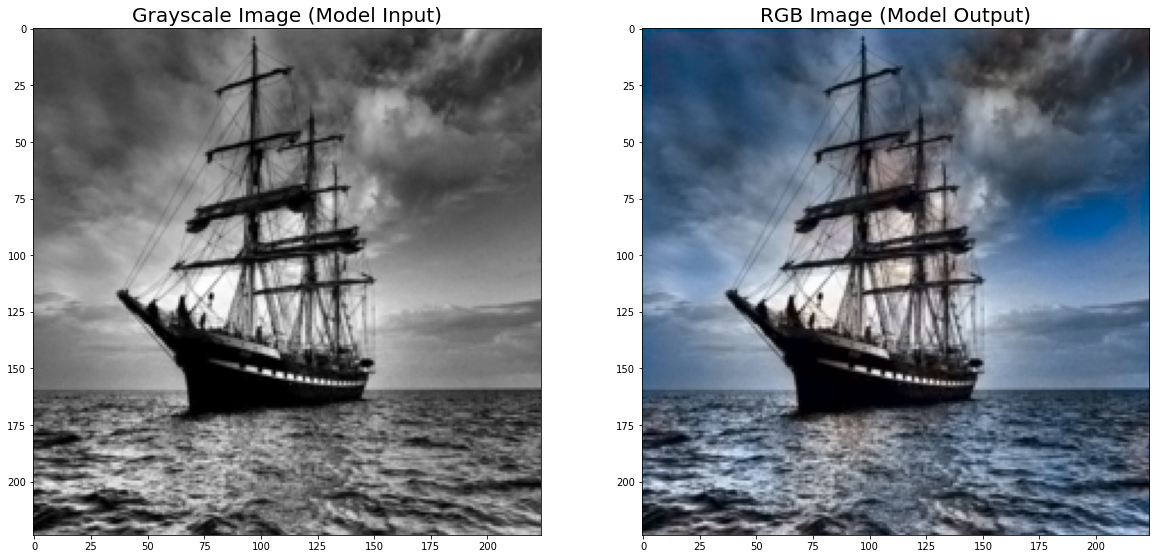

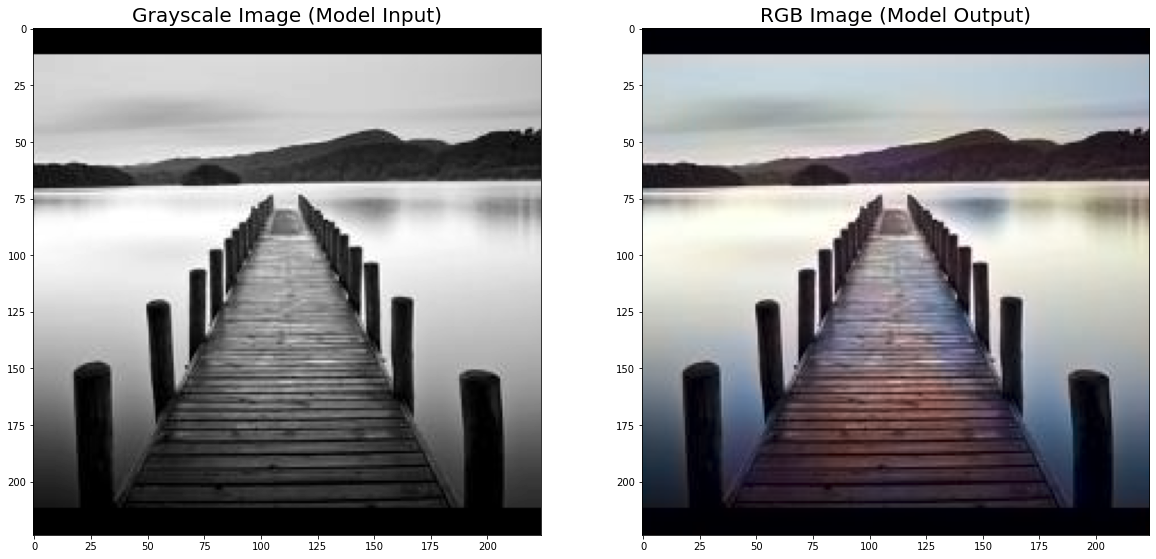

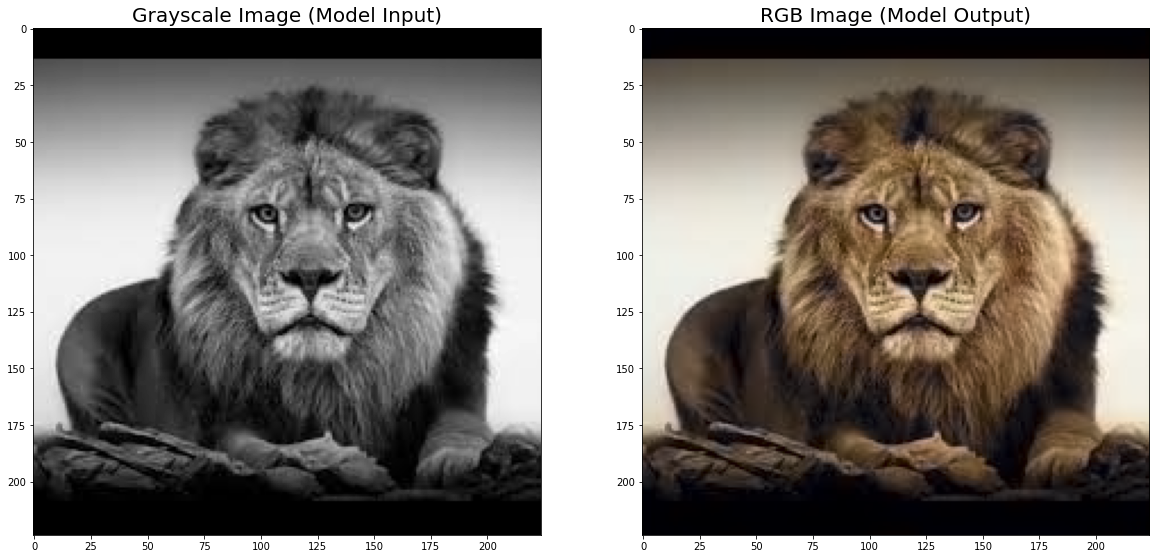

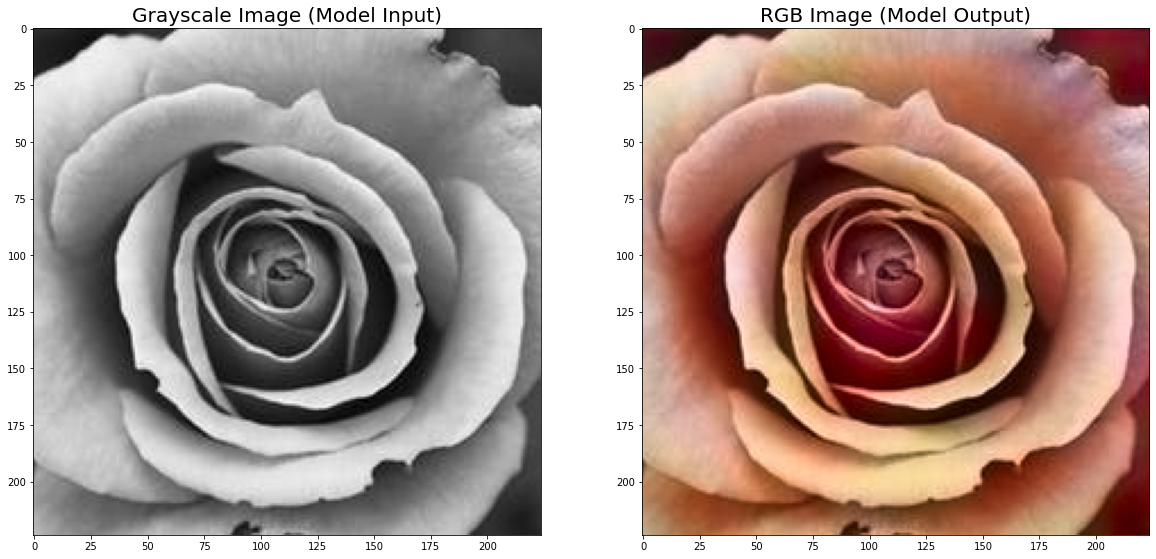

In [63]:
test_data = ImageDataset(f"{test_root}/no_ground_truth")
test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=4)

img_gray, img_ab, img_inception = iter(test_dataloader).next()
img_gray, img_ab, img_inception = img_gray.to(device), img_ab.to(device), img_inception.to(device)

model.eval()
with torch.no_grad():
    output = model(img_gray, img_inception)

for idx in range(4):
  grayscale, predicted_image, _ = convert_to_rgb(
      img_gray[idx].cpu(), 
      output[idx].cpu(), 
      img_ab[idx].cpu()
  )

  f, axarr = plt.subplots(1, 2, figsize=(20, 10))
  axarr[0].imshow(grayscale, cmap="gray")
  axarr[0].set_title("Grayscale Image (Model Input)", fontsize=20)
  axarr[1].imshow(predicted_image)
  axarr[1].set_title("RGB Image (Model Output)", fontsize=20)

### Images with Ground-truth 
The following images is a test set from ImageNet, so they all have ground truths. In other words, we can compare the model's outputs to the ground-truth for these images.

/usr/local/lib/python3.6/dist-packages/skimage/color/colorconv.py:1068: UserWarning: Color data out of range: Z < 0 in 33 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))
/usr/local/lib/python3.6/dist-packages/skimage/color/colorconv.py:1068: UserWarning: Color data out of range: Z < 0 in 34 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))
/usr/local/lib/python3.6/dist-packages/skimage/color/colorconv.py:1068: UserWarning: Color data out of range: Z < 0 in 1 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


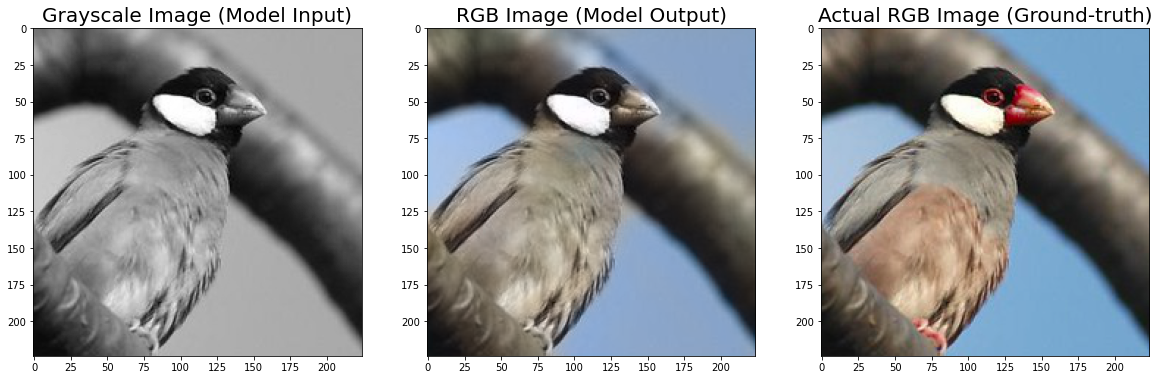

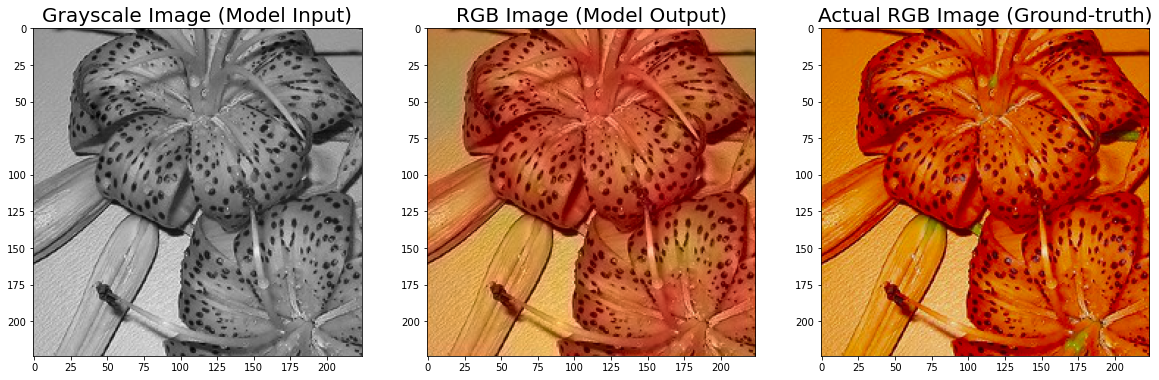

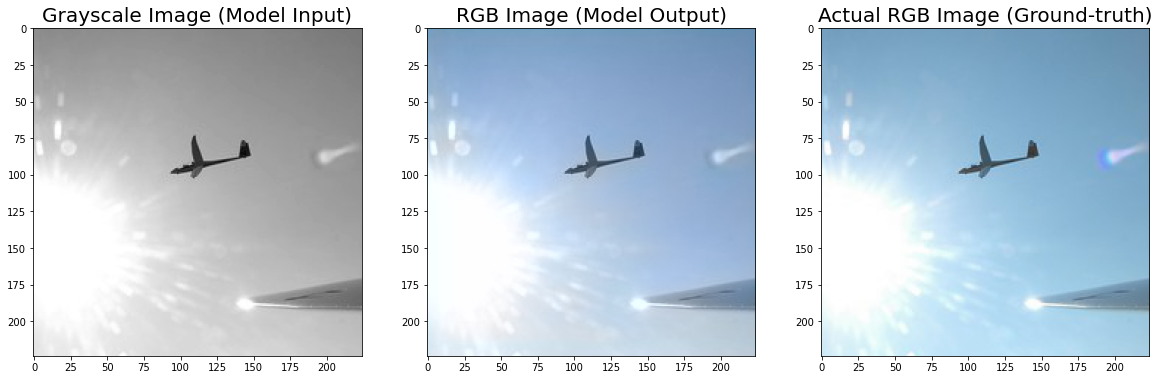

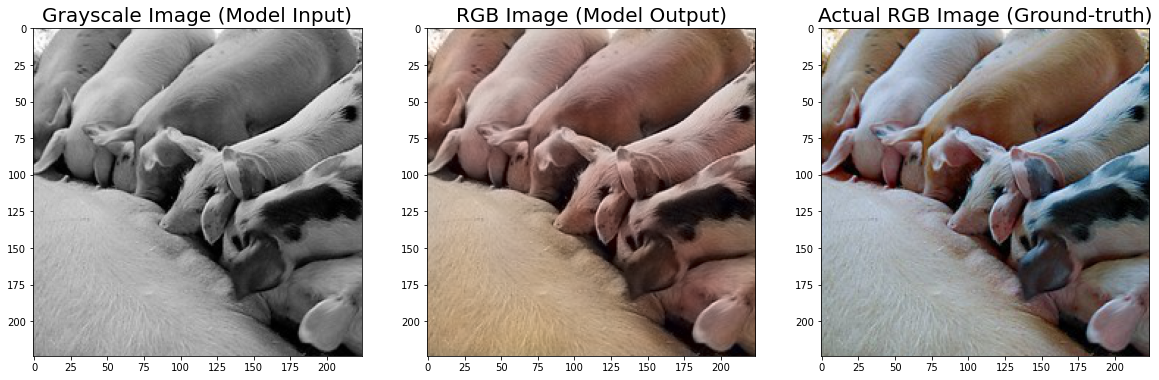

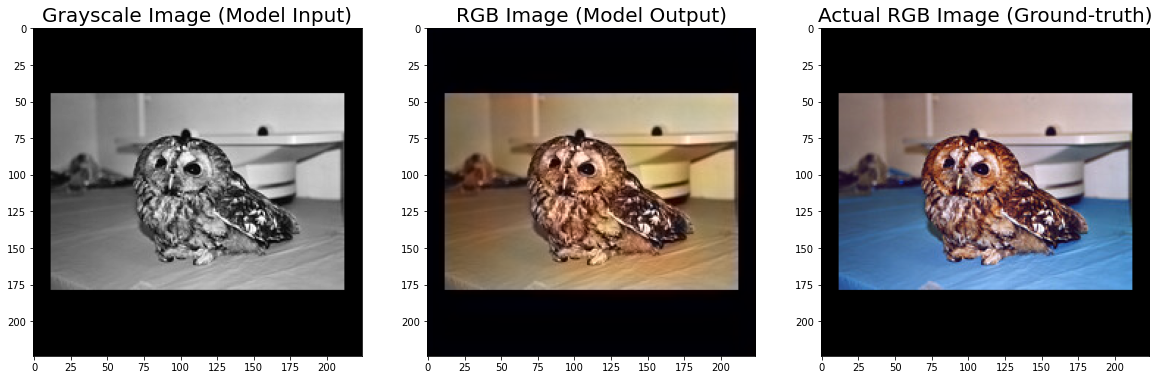

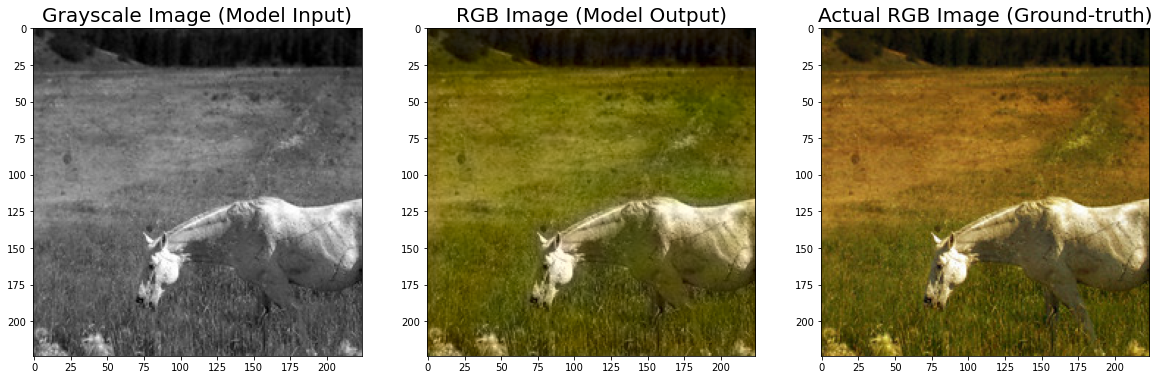

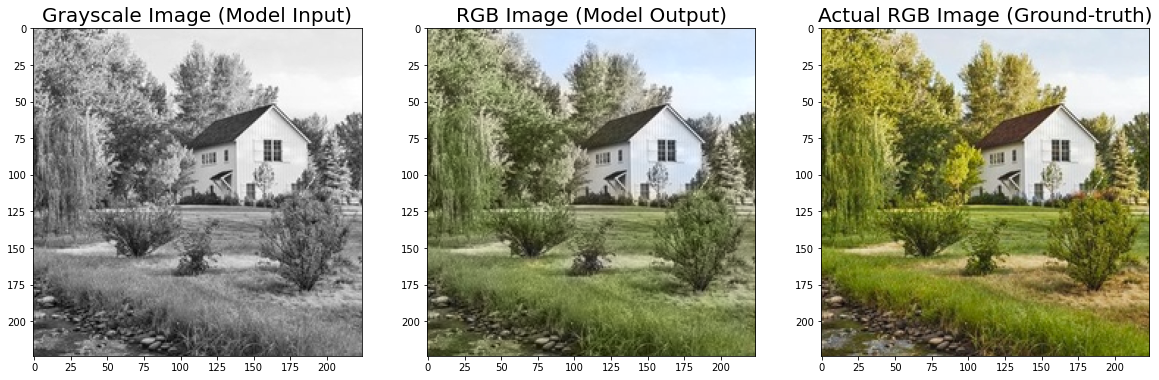

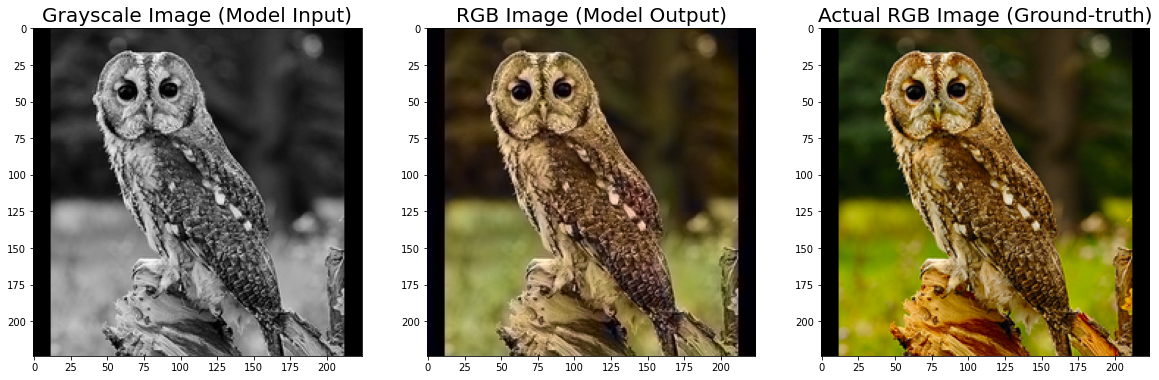

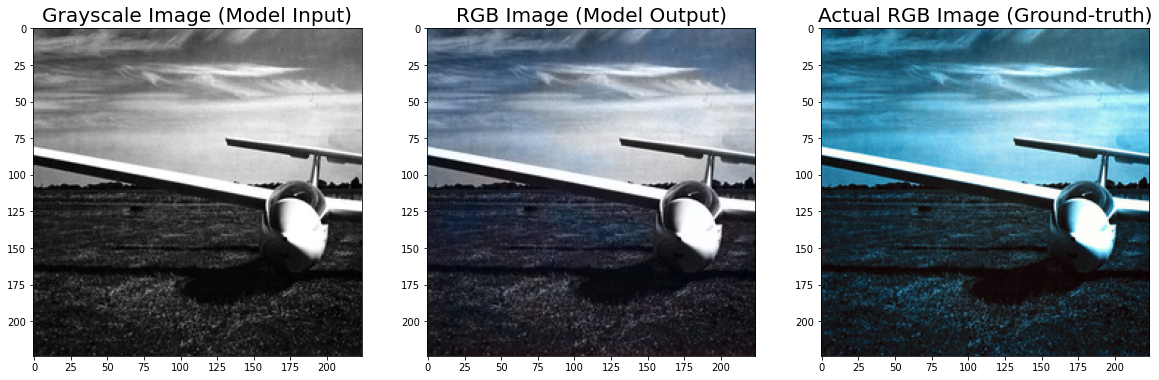

In [68]:
test_data = ImageDataset(f"{test_root}/has_ground_truth")
test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=9)

img_gray, img_ab, img_inception = iter(test_dataloader).next()
img_gray, img_ab, img_inception = img_gray.to(device), img_ab.to(device), img_inception.to(device)

model.eval()
with torch.no_grad():
    output = model(img_gray, img_inception)

for idx in range(9):
  grayscale, predicted_image, ground_truth = convert_to_rgb(
      img_gray[idx].cpu(), 
      output[idx].cpu(), 
      img_ab[idx].cpu()
  )

  display_images(grayscale, predicted_image, ground_truth)

## Conclusions
Because of limited GPU resources, this model was only trained for 33 epochs. However, we were still able to reach a validation loss of 0.002478. Even if some of the results were not too close to the ground-truth, many images can still pass as an acceptable coloured image. 

However, as stated in the paper, using the mean squared loss error function creates a sepia-tone in some images. In other words, it prevents bright colours from being generated since pixel values are averaged out. As an improvement, a cross entropy loss can be used instead.

Overall, this model can produce reasonable and convincing colourized images, but we can improve it by diversifying our training set (60 000 images were used), increasing the number of epochs, and experimenting with different loss functions to increase the colour vibrancy.